
# **Automatically classify consumer goods**

##***Preprocess image data to obtain a usable data set***

*Place de marché* is a company that wants to launch an e-commerce marketplace.
Manual classification of items by sellers is unreliable and limited.

As a Data Scientist within this company, I have to evaluate the feasibility of an automatic product classification system, using photos and descriptions. The process will involve data preprocessing, feature extraction, dimensionality reduction, and cluster analysis.

*NB: The images and descriptions as well as all the data used here are public data available on the website of the company “Marketplace” and are not intellectual property.*

<u><strong>Summary</strong></u> :<br>
<br>
<strong>Tools</strong> <a href="https://colab.research.google.com/drive/1P2prqyt9EdVdd3LU_DeyyZ8wA7cCc198#scrollTo=ad04d6df">(here)</a><br><br>
<strong>II. Preprocess image data to obtain a usable data set</strong><br>
     -- A. Data preparation <a href="https://colab.research.google.com/drive/1DV0UcL-pBE6yxTCLLBB5NDCZxVgXSPYR#scrollTo=f6165234&line=1&uniqifier=1">(here)</a><br>
     -- B. ORB and CNN features extraction <a href="https://colab.research.google.com/drive/1DV0UcL-pBE6yxTCLLBB5NDCZxVgXSPYR#scrollTo=WmNHQw32p3Oy&line=1&uniqifier=1">(here)</a><br>
     -- C. Visualization and analysis of features with T-SNE <a href="https://colab.research.google.com/drive/1P2prqyt9EdVdd3LU_DeyyZ8wA7cCc198#scrollTo=1jVzCEz7T8HP">(here)</a><br>
     -- D. Cluster analysis <a href="https://colab.research.google.com/drive/1DV0UcL-pBE6yxTCLLBB5NDCZxVgXSPYR#scrollTo=0pZbXKSPBDwU&line=1&uniqifier=1">(here)</a><br>

****

### **Tools**

In [113]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from PIL import Image
Image.LOAD_TRUNCATED_IMAGES = True

from matplotlib.collections import LineCollection
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image as k_image
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import cluster, metrics
from sklearn.metrics import silhouette_score
from keras.utils import to_categorical

warnings.filterwarnings('ignore')

In [115]:
def split_column(df, column_name):
    """
    Split a DataFrame column into multiple columns using space as the separator.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the column to split.
    column_name (str): The name of the column to split.

    Returns:
    pandas.DataFrame: A DataFrame with the original column split into multiple columns.
    """
    if column_name in df.columns:
        new_cols = df[column_name].str.split(',', expand=True)
        # Rename the new columns
        new_cols.columns = [
            f"{column_name}_{i}" for i in range(new_cols.shape[1])
        ]
        # Concatenate the new columns to the original DataFrame
        df = pd.concat([df, new_cols], axis=1)
    else:
        print(f"Column '{column_name}' not found in DataFrame.")

    return df

In [116]:
# Function to extract features from an image using ORB
def extract_orb_features(image_path, orb_detector):
    img = Image.open(image_path)
    img_gray = img.convert('L')  # Convert to grayscale
    img_gray_np = np.array(img_gray, dtype=np.uint8)
    keypoints, descriptors = orb_detector.detectAndCompute(img_gray_np, None)
    return descriptors

# Function to extract features from an image using a CNN
def extract_cnn_features(image_path, model, target_size):
    img = k_image.load_img(image_path, target_size=target_size)
    img_array = k_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    features = model.predict(img_array)
    features_reduced = np.mean(features, axis=(1, 2))  # Global Average Pooling
    return features_reduced.flatten()



---



## **I. Preprocess image data to obtain a usable data set**

### **A. Dataset preparation**

In [117]:
data = pd.read_csv(
    "/content/drive/MyDrive/flipkart_com-ecommerce_sample_1050.csv", sep=",")
data.shape

(1050, 15)

In [118]:
# New df
data = data[["uniq_id", "product_category_tree", "image"]]
data.head()

,uniq_id,product_category_tree,image
0,55b85ea15a1536d46b7190ad6fff8ce7,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg


In [119]:
# Removing special characters from the "product_category_tree" column
data['product_category_tree'] = data['product_category_tree'].str.replace(
    ">>", ",", regex=True)

# Call function to split column 'product_category_tree' of DataFrame 'data'
data = split_column(data, 'product_category_tree')
data['product_category_tree_0'] = data['product_category_tree_0'].astype(str)

# Remove special character
data['category'] = data['product_category_tree_0'].str.replace(
    "\['", "").str.replace("\W+", " ", regex=True).str.strip()

# Final df
data = data[["uniq_id", "category", "image"]]
data.head()

,uniq_id,category,image
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg


In [120]:
image_directory = '/content/drive/MyDrive/pix/'
target_size = (224, 224)  # Target size for VGG16

unique_ids = []
imgs_cnn = []

for file_name in os.listdir(image_directory):
    try:
        img = Image.open(os.path.join(image_directory, file_name))
        img_resized = img.resize(target_size)
        img_cnn = k_image.img_to_array(img_resized)
        img_cnn = np.expand_dims(img_cnn, axis=0)
        img_cnn = preprocess_input(img_cnn)  # Using VGG16 preprocess function
        imgs_cnn.append(img_cnn[0])
        unique_ids.append(file_name.split('.')[0])
    except (OSError, Exception) as e:
        print(f"Erreur de chargement pour l'image {file_name}: {e}")

data_img_cnn = pd.DataFrame({'unique_id': unique_ids, 'img_cnn': imgs_cnn})

Erreur de chargement pour l'image eaed0897074ee52230ff6c6d73c18dd4.jpg: image file is truncated (63 bytes not processed)
Erreur de chargement pour l'image f0bc8dff0e2ef0b75f1c78b4f67bcd63.jpg: image file is truncated (23 bytes not processed)
Erreur de chargement pour l'image e347e7eca70e01badc3bdf6c154ac7c4.jpg: image file is truncated (79 bytes not processed)
Erreur de chargement pour l'image 09f9f9b420edea2f39c0dc3c24d5be07.jpg: image file is truncated (36 bytes not processed)
Erreur de chargement pour l'image 22ac36ba254a68d7dd6173f099771147.jpg: image file is truncated (64 bytes not processed)
Erreur de chargement pour l'image 89b95537d8697203ab278237289a52a8.jpg: image file is truncated (40 bytes not processed)
Erreur de chargement pour l'image 789cf5578f48577a44586fca3adc35d0.jpg: image file is truncated (70 bytes not processed)
Erreur de chargement pour l'image 216c6c3527984be3d7ad9023d5cd9bd1.jpg: image file is truncated (90 bytes not processed)
Erreur de chargement pour l'imag

- An image directory is set up, and VGG16 is used for feature extraction from the images.
- Issues with loading images are caught and printed as errors, likely indicating that some images might be corrupt or in an incorrect format.

In [121]:
# Encoding categories
encode_fast = {
    'Home Furnishing': 0,
    'Baby Care': 1,
    'Watches': 2,
    'Home Decor Festive Needs': 3,
    'Kitchen Dining': 4,
    'Beauty and Personal Care': 5,
    'Computers': 6
}
data['encode_cat'] = data['category'].map(encode_fast)

# Function to retrieve encoded category by unique_id
def get_encoded_category(unique_id):
    return data[data['uniq_id'] == unique_id]['encode_cat'].item()

data_img_cnn['category_encoded'] = data_img_cnn['unique_id'].apply(get_encoded_category)

In [122]:
y_cat_num = data_img_cnn['category_encoded']
l_cat = list(data['category'].unique())
N_CLUSTERS = len(l_cat)
y = y_cat_num.values
NB_CLASSES = y.max() + 1
y_one_hot = to_categorical(y, num_classes=NB_CLASSES)

5


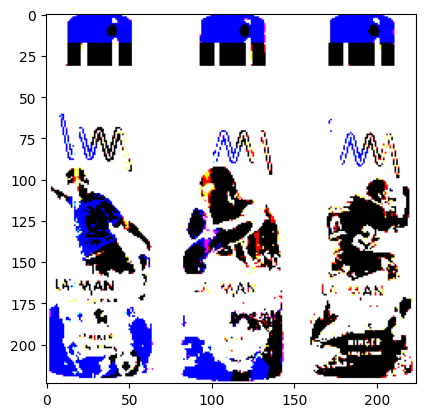

3


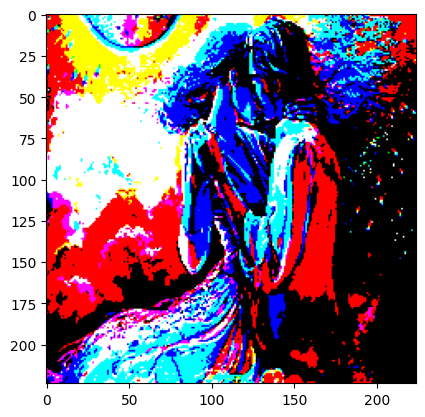

2


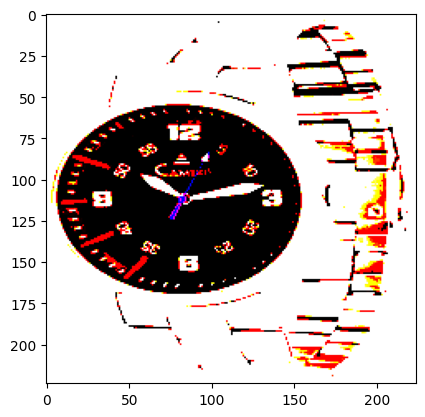

0


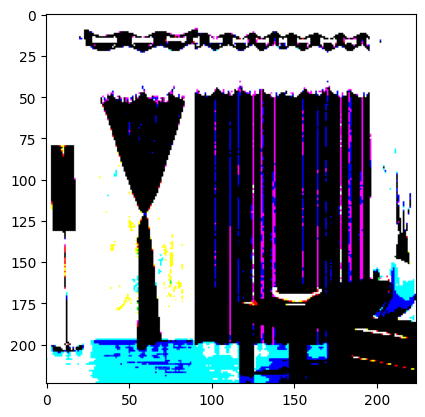

1


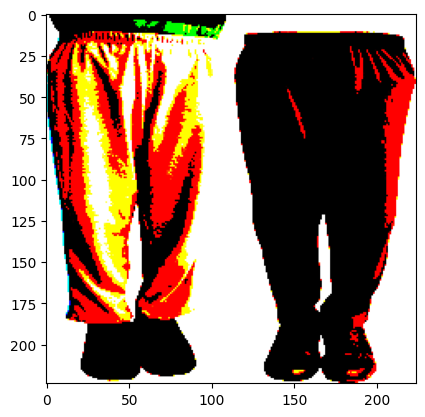

4


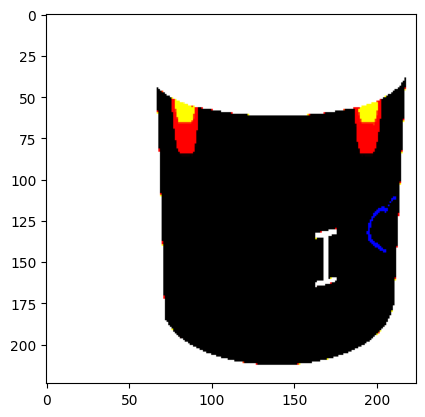

6


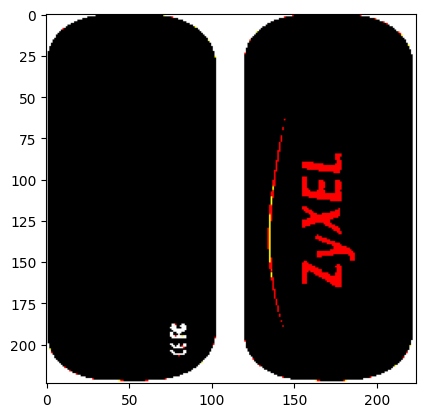

In [123]:
cat = list(data_img_cnn['category_encoded'].unique())
showed = []

while len(cat) > 0:
    unique_id = np.random.choice(list(data_img_cnn['unique_id']))
    row = data_img_cnn[data_img_cnn.unique_id == unique_id]
    if row['category_encoded'].item() not in showed:
        showed.append(row['category_encoded'].item())
        cat.remove(row['category_encoded'].item())
        print(row['category_encoded'].item())
        plt.imshow(row['img_cnn'].item())
        plt.show()

****

### **B. ORB and CNN features extraction**

In [124]:
# Initialize lists
unique_ids = []
orb_features = []
cnn_features = []

# Initialize ORB
orb = cv2.ORB_create()

# Load the VGG16 model pre-trained on ImageNet data
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Process images and extract features
for file_name in os.listdir(image_directory):
  try:
    img_path = os.path.join(image_directory, file_name)
    # Extract ORB features
    descriptors = extract_orb_features(img_path, orb)
    orb_features.append(descriptors)
    # Extract CNN features
    cnn_feat = extract_cnn_features(img_path, model, target_size)
    cnn_features.append(cnn_feat)
    unique_ids.append(file_name.split('.')[0])
  except (OSError, Exception) as e:
        print(f"Erreur de chargement pour l'image {file_name}: {e}")

# Convert the lists to DataFrames
data_orb_features = pd.DataFrame({'unique_id': unique_ids, 'orb_features': orb_features})
data_cnn_features = pd.DataFrame({'unique_id': unique_ids, 'cnn_features': list(cnn_features)})

1/1 [==============================] - 0s 18ms/step
Erreur de chargement pour l'image eaed0897074ee52230ff6c6d73c18dd4.jpg: image file is truncated (63 bytes not processed)
1/1 [==============================] - 0s 18ms/step
Erreur de chargement pour l'image f0bc8dff0e2ef0b75f1c78b4f67bcd63.jpg: image file is truncated (23 bytes not processed)
1/1 [==============================] - 0s 18ms/step
Erreur de chargement pour l'image e347e7eca70e01badc3bdf6c154ac7c4.jpg: image file is truncated (79 bytes not processed)
1/1 [==============================] - 0s 18ms/step
Erreur de chargement pour l'image 09f9f9b420edea2f39c0dc3c24d5be07.jpg: image file is truncated (36 bytes not processed)
1/1 [==============================] - 0s 18ms/step
Erreur de chargement pour l'image 22ac36ba254a68d7dd6173f099771147.jpg: image file is truncated (64 bytes not processed)
1/1 [==============================] - 0s 20ms/step
Erreur de chargement pour l'image 89b95537d8697203ab278237289a52a8.jpg: image file 

In [125]:
data_orb_features.head(2)

,unique_id,orb_features
0,0e73201f6d8807776e1d21c969078289,"[[95, 180, 252, 94, 187, 118, 222, 249, 27, 23..."
1,3c4604dba348a99a2dfbbc2cd3928101,"[[49, 47, 106, 33, 20, 139, 227, 96, 116, 164,..."


### **C. Applying T-SNE to CNN Features**

Reducing dimensions with PCA prior to t-SNE helps streamline computations, clarify data structure, and retain the most informative features. This pre-processing enhances t-SNE’s ability to visually distinguish between clusters in a two-dimensional space. It's an effective strategy for managing high-dimensional data and improving the interpretability of our results.


In [126]:
# Conversion of stored images into a NumPy array, required here for machine learning processing
cnn_features = np.array(data_cnn_features['cnn_features'].tolist())
cnn_features.shape

(1027, 512)

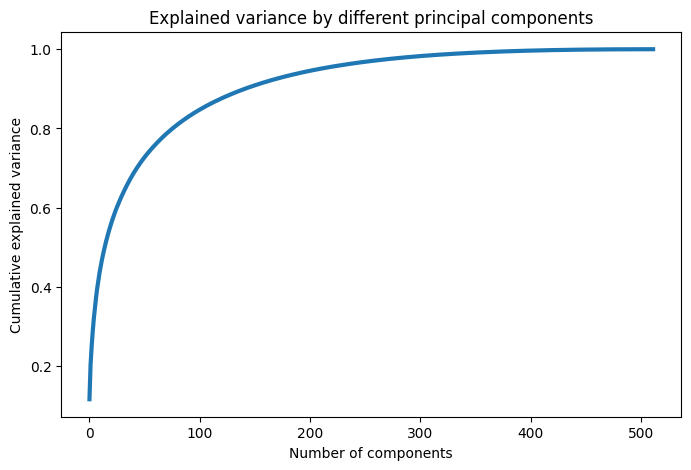

Number of components explaining 80% variance: 77


In [127]:
# Fit PCA on your features without specifying the number of components to retain all of them
pca = PCA().fit(cnn_features)

# Calculate the cumulative sum of explained variances
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance, lw=3)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance by different principal components')
plt.show()

# Find the number of components that explain at least 95% of the variance
n_components_80 = np.where(cumulative_explained_variance >= 0.80)[0][0] + 1

print(f"Number of components explaining 80% variance: {n_components_80}")

# You can then use this number to reduce your features
pca = PCA(n_components=n_components_80)
cnn_features_pca = pca.fit_transform(cnn_features)

In [128]:
# Now apply t-SNE to the PCA-reduced data
tsne = TSNE(n_components=2, random_state=0)  # n_components=2 for 2D visualization
cnn_features_tsne = tsne.fit_transform(cnn_features_pca)
# Calculate the silhouette score
data_filtered = data[data['uniq_id'].isin(unique_ids)]
labels = data_filtered["category"].values
score = silhouette_score(cnn_features_tsne, labels)
print(f"Silhouette Score: {score}")

Silhouette Score: -0.04815360903739929


- **Results visualization with data real categories**

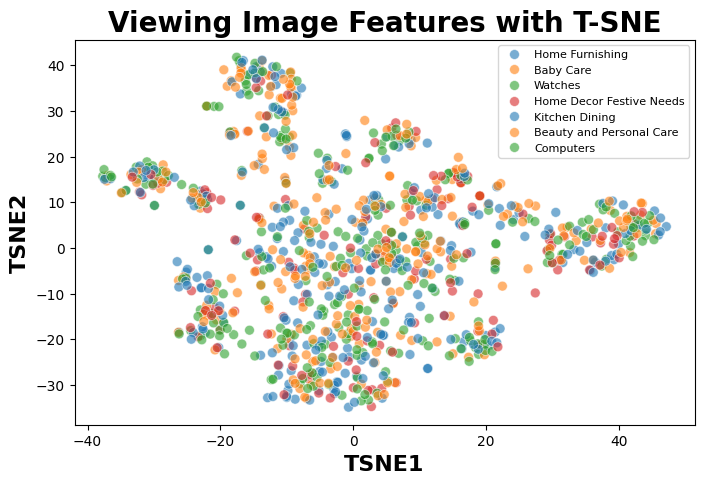

In [129]:
tsne_df = pd.DataFrame(cnn_features_tsne, columns=['TSNE1', 'TSNE2'])

tsne_df["class"] = data["category"]

plt.figure(figsize=(8, 5))
sns.scatterplot(x="TSNE1",
                y="TSNE2",
                hue="class",
                palette=sns.color_palette('tab10', n_colors=4),
                s=50,
                alpha=0.6,
                data=tsne_df,
                legend="brief")

plt.title('Viewing Image Features with T-SNE', fontsize=20, fontweight='bold')
plt.xlabel('TSNE1', fontsize=16, fontweight='bold')
plt.ylabel('TSNE2', fontsize=16, fontweight='bold')
plt.legend(prop={'size': 8})

plt.show()

- **Creation of clusters from T-SNE and display of images according to clusters**

The graphical analysis visually shows that it is feasible to automatically separate the images into 4 categories if we group the categories 'Kitchen Dining' and 'Home furnishing', 'Personal care' and 'Baby care' as well as 'Watches' and ' Computer’.

We can demonstrate the feasibility of automatically determining the category of an image using a supervised classification model like the KMeans model.

In [130]:
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(cnn_features_tsne)

KMeans(n_clusters=7, n_init=100)

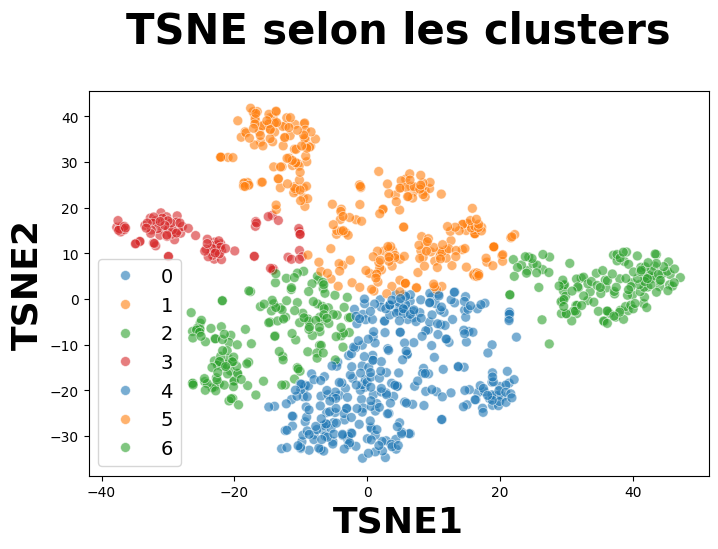

ARI :  -5.603822485243634e-05


In [131]:
tsne_df["cluster"] = cls.labels_

plt.figure(figsize=(8, 5))
sns.scatterplot(x="TSNE1",
                y="TSNE2",
                hue="cluster",
                palette=sns.color_palette('tab10', n_colors=4),
                s=50,
                alpha=0.6,
                data=tsne_df,
                legend="brief")

plt.title('TSNE selon les clusters', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('TSNE1', fontsize=26, fontweight='bold')
plt.ylabel('TSNE2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14})

plt.show()
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### **D. Cluster analysis and conclusion**

**Analysis of 2D TSNE graphics**
- A negative ARI close to 0 suggests that the cluster assignments are somewhat random. However, this also indicates that there is no inherent structure being violated by the clustering.
- A negative silhouette score of -0.049 reveals that clusters are not well-separated and that some datapoints may be assigned to the wrong cluster.
- Fine-tuning the pre-trained model can indeed be a necessary step.

**Conclusion for Feasibility Study**
- The clustering and visualization show that it's feasible to categorize images into groups, which is promising for the goal of automatic product classification.
- The negative ARI score indicates there might be room for improvement in either the feature extraction process, the dimensionality reduction steps, or the clustering algorithm.
- To move forward with the feasibility study, it would be important to optimize the machine learning pipeline, ensuring the data quality, refining the model parameters, and possibly incorporating additional features or using different models. Further validation with a labeled test set would be essential to confirm the model's performance.
